### 📢 Don't forget to upvote if you enjoy my work :)
# EV Dataset 2025: End-to-End EDA and Predictive Modeling
## Introduction
The global shift toward sustainable mobility has made electric vehicles (EVs) one of the fastest-growing segments in the automotive industry. Battery technology, charging infrastructure, safety, and affordability all influence how quickly EVs are adopted across different markets.

This dataset provides 3,000+ synthetic EV records that cover technical specifications, pricing, safety, and sales figures across multiple manufacturers and years. Each record represents a unique vehicle model or trim, including both battery-electric vehicles (BEVs) and plug-in hybrids (PHEVs).

In this notebook, we will explore three guiding questions:

1. EV Sales in 2024
Can specs, price and safety explain adoption?
By analyzing how technical and market attributes affect the number of units sold in 2024, we can identify which factors most strongly influence consumer adoption.

2. Driving Range (km)
How well can we estimate real-world performance from battery capacity and chemistry?
EV range is one of the most critical considerations for buyers. We will test whether specifications such as battery capacity, battery type, and manufacturer can reliably predict range.

3. Price (USD)
Can we predict price ranges using technical and safety attributes, with quantile regression to capture uncertainty?
Pricing reflects both cost and market positioning. By predicting EV prices from technical attributes and safety ratings, we aim to uncover how performance and safety features translate into pricing strategies.

Along the way, we will also perform an exploratory data analysis (EDA) to better understand the dataset, engineer meaningful features such as efficiency and charge speed, and use machine learning models (linear models, tree-based methods, and quantile regression) to answer these questions.

Our ultimate goal is to combine insightful EDA with predictive modeling to better understand the EV landscape and highlight the factors shaping adoption, performance, and pricing.

# Data Overview
Before diving into analysis, let’s take a closer look at the dataset. It contains 3,000+ vehicle records with a mix of numerical, categorical, and derived attributes. Each row represents a unique vehicle model or trim, identified by Vehicle_ID.
Key Columns:
- Manufacturer, Model, Year - Brand, variant, and release year.
- Battery_Type, Battery_Capacity_kWh - Chemistry and energy storage size.
- Range_km - Claimed driving range per full charge.
- Charging_Type, Charge_Time_hr - Charging interface and estimated time.
- Price_USD - Indicative vehicle price.
- Country_of_Manufacture - Origin of production.
- Autonomous_Level - Automation capability (0–5).
- CO2_Emissions_g_per_km - Tailpipe emissions (BEVs typically = 0).
- Safety_Rating - Safety performance score.
- Units_Sold_2024 - Recorded sales for the year 2024.
- Warranty_Years - Warranty duration.

Initial Checks:
- Shape: The dataset has ~3,000 rows and ~16 columns.
- Data Types: A mix of integers, floats, and categorical values.
- Missing Values: Some fields (e.g., emissions, safety ratings, autonomy levels) are incomplete and will require imputation or careful handling.
- Inconsistent Labels: Charging types and battery types are heterogeneous (e.g., “CCS” vs. “DCFC”, “Lithium-ion” vs. “Li-ion”). Standardization will improve analysis.
- Units: Values are expressed in different scales (kWh, km, hr, USD, g/km). Feature scaling may be required for modeling.

The analysis is centered on predicting Range_km, which represents the real-world driving range of electric vehicles. This variable serves as the primary performance indicator and the focal point of all subsequent modeling steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option("display.max_columns", None)

dataset_url = '/kaggle/input/ev-electrical-vehicles-dataset-3k-records-2025/electric_vehicles_dataset.csv'
df = pd.read_csv(dataset_url, index_col='Vehicle_ID')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Manufacturer,Model,Year,Battery_Type,Battery_Capacity_kWh,Range_km,Charging_Type,Charge_Time_hr,Price_USD,Color,Country_of_Manufacture,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years
Vehicle_ID,,,,,,,,,,,,,,,,
1,Acura,ZDX (with GM Ultium),2015,Lithium-titanate,55.8,214,CHAdeMO,9.0,111203.94,Matte White,UK,0.0,NaN,5.0,19726,3
2,Lamborghini,Revuelto (PHEV),2025,Lithium-titanate,90.8,212,Vehicle-to-Home (V2H),7.3,127131.65,White,Netherlands,2.0,0.0,4.0,3349,3
3,NIO,ET7,2020,Calcium-ion,64.7,235,Level 2 Charging,8.9,94347.37,Beige,UK,5.0,0.0,5.0,6300,5
4,Audi,e-tron,2025,Lithium-iron phosphate,120.5,140,Ultra-Fast Charging (350 kW+),10.5,75615.15,Sunset Orange,Argentina,2.0,0.0,5.0,2339,5
5,Acura,ZDX (with GM Ultium),2023,Lithium-titanate,51.8,336,Plug-in Hydrogen Refueling,3.6,141046.94,Ice Silver,United Arab Emirates,2.0,0.0,3.0,1051,4


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3022 entries, 1 to 3022
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            3022 non-null   object 
 1   Model                   3022 non-null   object 
 2   Year                    3022 non-null   int64  
 3   Battery_Type            3022 non-null   object 
 4   Battery_Capacity_kWh    3022 non-null   float64
 5   Range_km                3022 non-null   int64  
 6   Charging_Type           3022 non-null   object 
 7   Charge_Time_hr          3022 non-null   float64
 8   Price_USD               3022 non-null   float64
 9   Color                   3022 non-null   object 
 10  Country_of_Manufacture  3022 non-null   object 
 11  Autonomous_Level        2580 non-null   float64
 12  CO2_Emissions_g_per_km  2430 non-null   float64
 13  Safety_Rating           2685 non-null   float64
 14  Units_Sold_2024         3022 non-null   int64

In [3]:
df.isnull().sum().sort_values(ascending=False)

CO2_Emissions_g_per_km    592
Autonomous_Level          442
Safety_Rating             337
Manufacturer                0
Model                       0
Year                        0
Battery_Type                0
Battery_Capacity_kWh        0
Range_km                    0
Charging_Type               0
Charge_Time_hr              0
Price_USD                   0
Color                       0
Country_of_Manufacture      0
Units_Sold_2024             0
Warranty_Years              0
dtype: int64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,3022.0,2020.019523,3.132083,2015.00,2017.000,2020.000,2023.0000,2025.00
Battery_Capacity_kWh,3022.0,84.314692,37.210461,20.00,52.425,83.600,115.8000,150.00
Range_km,3022.0,349.901059,145.406139,100.00,222.000,347.000,478.0000,600.00
Charge_Time_hr,3022.0,6.212045,3.350597,0.50,3.300,6.200,9.1000,12.00
Price_USD,3022.0,90611.906760,34654.533838,30014.46,61257.390,90929.705,120199.8425,149978.53
Autonomous_Level,2580.0,2.519380,1.713712,0.00,1.000,3.000,4.0000,5.00
CO2_Emissions_g_per_km,2430.0,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
Safety_Rating,2685.0,3.995158,0.819594,3.00,3.000,4.000,5.0000,5.00
Units_Sold_2024,3022.0,10207.072799,5771.619003,6.00,5145.500,10350.000,15128.0000,19996.00
Warranty_Years,3022.0,3.997353,0.821746,3.00,3.000,4.000,5.0000,5.00


In [5]:
df.describe(include=['object']).T

,count,unique,top,freq
Manufacturer,3022,53,Ferrari,78
Model,3022,181,Nevera,68
Battery_Type,3022,15,Lithium-titanate,233
Charging_Type,3022,16,Mobile Charging,206
Color,3022,55,Ruby Red,77
Country_of_Manufacture,3022,40,Singapore,92


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of EV Prices (USD)')

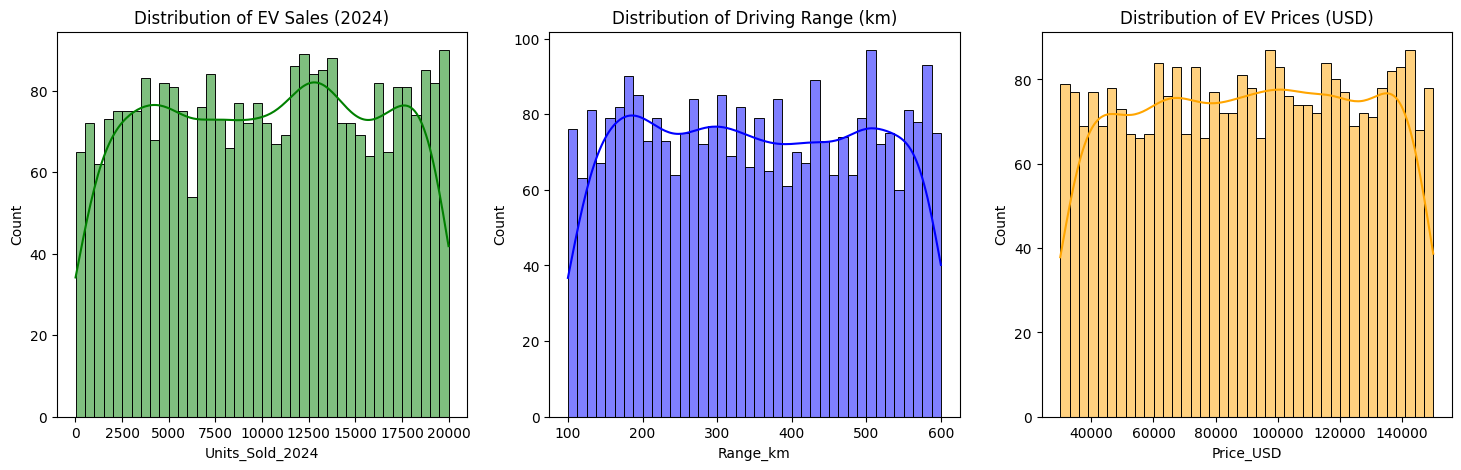

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Units_Sold_2024'], bins=40, kde=True, ax=axs[0], color='green')
axs[0].set_title("Distribution of EV Sales (2024)")

sns.histplot(df["Range_km"], bins=40, kde=True, ax=axs[1], color="blue")
axs[1].set_title("Distribution of Driving Range (km)")

sns.histplot(df["Price_USD"], bins=40, kde=True, ax=axs[2], color="orange")
axs[2].set_title("Distribution of EV Prices (USD)")

Text(0, 0.5, 'Manufacturer')

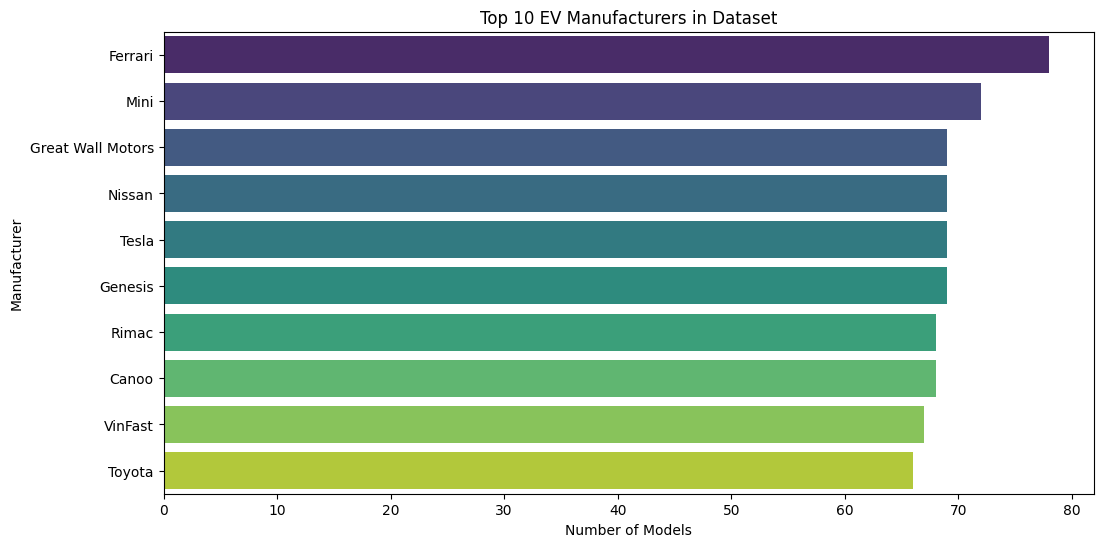

In [7]:
plt.figure(figsize=(12,6))
top_brands = df["Manufacturer"].value_counts().head(10).sort_values(ascending=False)
sns.barplot(y=top_brands.index, x=top_brands.values, palette="viridis")
plt.title("Top 10 EV Manufacturers in Dataset")
plt.xlabel("Number of Models")
plt.ylabel("Manufacturer")

Text(0.5, 1.0, 'Distribution of vehicles by Year')

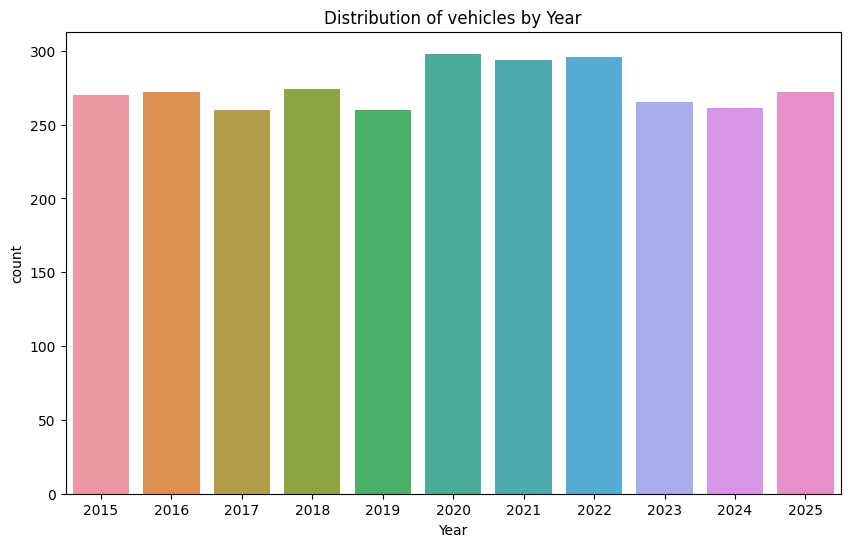

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x = df.Year)
plt.title('Distribution of vehicles by Year')

# Data Cleaning & Preprocessing

In [9]:
df.dtypes

Manufacturer               object
Model                      object
Year                        int64
Battery_Type               object
Battery_Capacity_kWh      float64
Range_km                    int64
Charging_Type              object
Charge_Time_hr            float64
Price_USD                 float64
Color                      object
Country_of_Manufacture     object
Autonomous_Level          float64
CO2_Emissions_g_per_km    float64
Safety_Rating             float64
Units_Sold_2024             int64
Warranty_Years              int64
dtype: object

In [10]:
df['Autonomous_Level'].unique()

array([ 0.,  2.,  5., nan,  1.,  3.,  4.])

In [11]:
df[df['Autonomous_Level'].isnull()].head(3)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Manufacturer,Model,Year,Battery_Type,Battery_Capacity_kWh,Range_km,Charging_Type,Charge_Time_hr,Price_USD,Color,Country_of_Manufacture,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years
Vehicle_ID,,,,,,,,,,,,,,,,
6,XPeng,G9,2016,Lithium-iron phosphate,138.7,390,Mobile Charging,2.9,89907.75,Ruby Red,Australia,NaN,NaN,5.0,8609,5
8,Changan,Q05,2019,Lead-acid,131.9,105,CCS,8.3,94436.44,Bronze,Mexico,NaN,0.0,5.0,8630,5
10,Rimac,Nevera,2015,Solid-state,140.8,549,Solar Charging,3.3,58904.59,Matte Green,UK,NaN,0.0,NaN,17455,3


In [12]:
df['Autonomous_Level'] = df['Autonomous_Level'].fillna('Unknown')
df['Autonomous_Level'] = df['Autonomous_Level'].astype('category')
df['Autonomous_Level'].dtype

CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 'Unknown'], ordered=False, categories_dtype=object)

In [13]:
df['Safety_Rating'] = df['Safety_Rating'].fillna('Unknown')
df['Safety_Rating'] = df['Safety_Rating'].astype('category')
df['Safety_Rating'].dtype

CategoricalDtype(categories=[3.0, 4.0, 5.0, 'Unknown'], ordered=False, categories_dtype=object)

In [14]:
df["Powertrain"] = np.where(df["CO2_Emissions_g_per_km"].fillna(0) <= 1, "BEV", "PHEV")

def fill_co2(row):
    if pd.isna(row["CO2_Emissions_g_per_km"]):
        if row["Powertrain"] == "BEV":
            return 0.0
        else:  # PHEV
            return df.loc[df["Powertrain"]=="PHEV", "CO2_Emissions_g_per_km"].mean()
    else:
        return row["CO2_Emissions_g_per_km"]

df["CO2_Emissions_g_per_km"] = df.apply(fill_co2, axis=1)


In [15]:
df.isnull().sum().sum()

0

In [16]:
df["Powertrain"] = df["Powertrain"].astype("category")

In [17]:
df.dtypes

Manufacturer                object
Model                       object
Year                         int64
Battery_Type                object
Battery_Capacity_kWh       float64
Range_km                     int64
Charging_Type               object
Charge_Time_hr             float64
Price_USD                  float64
Color                       object
Country_of_Manufacture      object
Autonomous_Level          category
CO2_Emissions_g_per_km     float64
Safety_Rating             category
Units_Sold_2024              int64
Warranty_Years               int64
Powertrain                category
dtype: object

In [18]:
df['Model'].value_counts().sum()

3022

In [19]:
cat_cols = ["Manufacturer","Battery_Type","Charging_Type",
            "Country_of_Manufacture","Color"]

for c in cat_cols:
    df[c] = df[c].astype('category')

df.dtypes

Manufacturer              category
Model                       object
Year                         int64
Battery_Type              category
Battery_Capacity_kWh       float64
Range_km                     int64
Charging_Type             category
Charge_Time_hr             float64
Price_USD                  float64
Color                     category
Country_of_Manufacture    category
Autonomous_Level          category
CO2_Emissions_g_per_km     float64
Safety_Rating             category
Units_Sold_2024              int64
Warranty_Years               int64
Powertrain                category
dtype: object

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


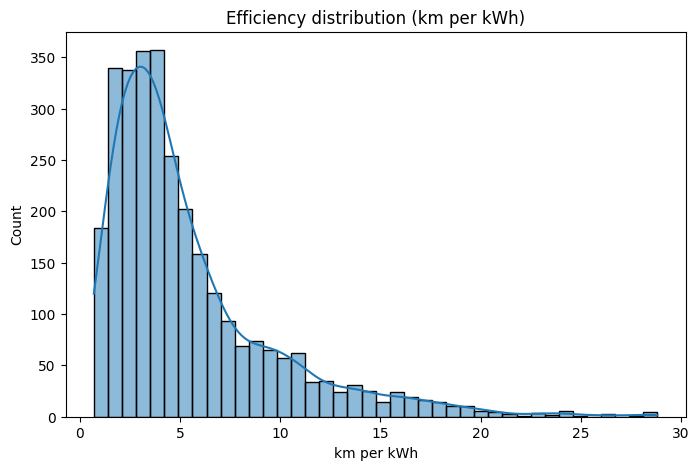

count    3022.000000
mean        5.444689
std         4.267455
min         0.696072
25%         2.595142
50%         4.070454
75%         6.707462
max        28.823529
Name: efficiency_km_per_kWh, dtype: float64

In [20]:
df['efficiency_km_per_kWh'] = df['Range_km'] / df['Battery_Capacity_kWh']

plt.figure(figsize=(8, 5))
sns.histplot(df['efficiency_km_per_kWh'], bins=40, kde=True)
plt.title('Efficiency distribution (km per kWh)')
plt.xlabel("km per kWh")
plt.show()
df['efficiency_km_per_kWh'].describe()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


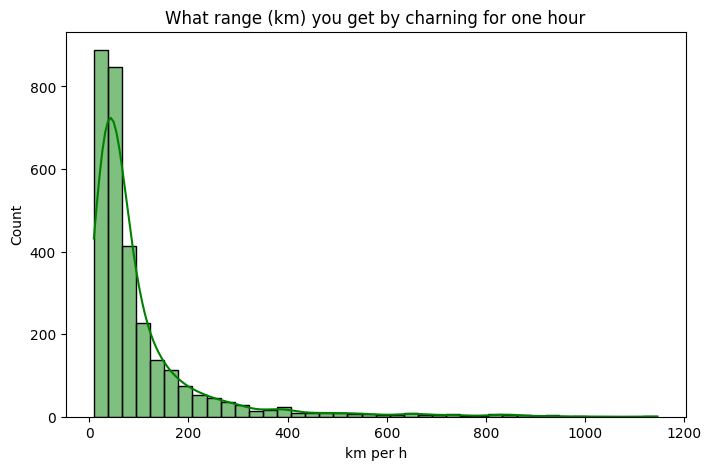

count    3022.000000
mean       99.610217
std       126.762792
min         9.051724
25%        33.929335
50%        56.528673
75%       109.047826
max      1146.000000
Name: Range_per_charge_hour, dtype: float64

In [21]:
df["Range_per_charge_hour"] = df["Range_km"] / df["Charge_Time_hr"]

plt.figure(figsize=(8, 5))
sns.histplot(df["Range_per_charge_hour"], bins=40, kde=True, color='green')
plt.title('What range (km) you get by charning for one hour')
plt.xlabel("km per h")
plt.show()
df["Range_per_charge_hour"].describe()

## Train / Test Split

In [22]:
from sklearn.model_selection import train_test_split
def get_train_test(target, data):
    X = data.drop(columns=target)
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Predictive Modeling
## Range_km - Real-world driving performance.

In [23]:
df_clean = df.copy()
df_clean = df_clean.drop(columns=['Model', 'Color'])
df_clean.head(3)

,Manufacturer,Year,Battery_Type,Battery_Capacity_kWh,Range_km,Charging_Type,Charge_Time_hr,Price_USD,Country_of_Manufacture,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years,Powertrain,efficiency_km_per_kWh,Range_per_charge_hour
Vehicle_ID,,,,,,,,,,,,,,,,,
1,Acura,2015,Lithium-titanate,55.8,214,CHAdeMO,9.0,111203.94,UK,0.0,0.0,5.0,19726,3,BEV,3.835125,23.777778
2,Lamborghini,2025,Lithium-titanate,90.8,212,Vehicle-to-Home (V2H),7.3,127131.65,Netherlands,2.0,0.0,4.0,3349,3,BEV,2.334802,29.041096
3,NIO,2020,Calcium-ion,64.7,235,Level 2 Charging,8.9,94347.37,UK,5.0,0.0,5.0,6300,5,BEV,3.632148,26.404494


In [24]:
manufacturer_counts = df_clean['Manufacturer'].value_counts()
df_clean['Manufacturer_freq'] = df_clean['Manufacturer'].map(manufacturer_counts)
df_clean = df_clean.drop(columns=['Manufacturer'])
df_clean[["Manufacturer_freq"]].head()

,Manufacturer_freq
Vehicle_ID,
1,55
2,62
3,55
4,60
5,55


In [25]:
cat_cols = ['Battery_Type', 'Charging_Type', 'Country_of_Manufacture',
       'Autonomous_Level', 'Safety_Rating', 'Powertrain']

df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
df_encoded.shape

(3022, 88)

In [26]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = get_train_test("Range_km", df_encoded)

num_cols = ['Year', 'Battery_Capacity_kWh', 'Charge_Time_hr',
       'Price_USD', 'CO2_Emissions_g_per_km', 'Units_Sold_2024',
       'Warranty_Years', 'efficiency_km_per_kWh', 'Range_per_charge_hour',
       'Manufacturer_freq']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 92.41896791933526
R²: 0.5774947890320068


In [28]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR RMSE:", rmse_svr)
print("SVR R²:", r2_svr)

SVR RMSE: 27.36738086207899
SVR R²: 0.9629510150859176


# Conclusion
In this notebook we explored the EV dataset, presented its key characteristics, and performed feature engineering by creating two new variables. We then built and evaluated two predictive models - Linear Regression and Support Vector Regression - to estimate driving range based on vehicle specifications.

Thank you for reading!
Feel free to check out my other notebooks and projects on my profile for more analyses and experiments.